In [17]:
# !python3 -m pip install tensorflow-gpu tensorflow-hub opencv-python matplotlib
!python3 -m pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=2c84e27bc227b8a62caff9cba469271db93750ca2eb3584639cfa6aea780b4e2
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\85\cf\3a\e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np
from imutils.video import VideoStream

In [3]:
# Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

In [5]:
# Load model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [6]:
# Draw keypoints
def draw_keypoints(frame,keypoints,confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1)

In [7]:
# Draw edges
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [8]:
# keypoints_with_scores[0]
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [9]:
# frame.shape
480/640

0.75

In [10]:
# frame.shape
# # 40*0.5625*32
# print(frame.shape[0])
# print(frame.shape[1])
# ratio256 = int(frame.shape[1]/256)
# # ratio = frame.shape[0]/frame.shape[1]
# ratio = frame.shape[0]/frame.shape[1]
# # width = int(256*ratio256/32)*32
# width = 256
# height = int((ratio * width)/32)*32
# print(height, width, ratio,height/width)
# 480/256
# 32*20

In [20]:
# Make detections
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('gym.mp4')
printed = False
while cap.isOpened():
    ret, tempframe = cap.read()

    if ret:
        # Resize image and detect
        frame = tempframe
        img = frame.copy()

        ratio = frame.shape[0]/frame.shape[1]
        width = 256
        height = int((ratio * width)/32)*32
        if not printed:
            print(height, width)
            printed = True

        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), height, width)
        input_img = tf.cast(img, dtype=tf.int32)

        # print(type(img))
        # frame = cv2.resize(frame, (width, height))

        # Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        # print(keypoints_with_scores)

        # Render keypoints
        loop_through_people(frame, keypoints_with_scores, EDGES, 0.3)

        # cv2.imshow('Movenet Multipose', frame)
        cv2.namedWindow('Movenet Multipose', cv2.WINDOW_KEEPRATIO)
        cv2.imshow('Movenet Multipose', frame)
        cv2.resizeWindow('Movenet Multipose', 640, 352)

        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    else:
        break
    
cap.release()
cv2.destroyAllWindows()

128 256


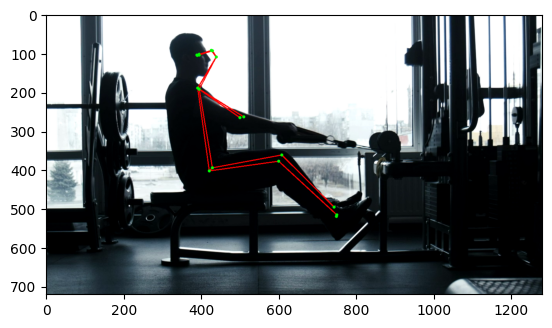

In [12]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


In [13]:
results.keys()

dict_keys(['output_0'])

In [14]:
# y,x,score*17 (có 17 điểm trên khung xương, mỗi điểm có 1 tuple 3 giá trị là y, x, độ tin cậy)
3 * 17

51

In [15]:
results['output_0'].numpy()[:,:,:51]

array([[[1.5352269e-01, 3.4340113e-01, 5.2817911e-01, 1.2979901e-01,
         3.3351001e-01, 6.2655634e-01, 1.3082722e-01, 3.3568475e-01,
         5.9694529e-01, 1.4764407e-01, 3.0538243e-01, 6.3489401e-01,
         1.4324348e-01, 3.0913550e-01, 5.5641228e-01, 2.6873767e-01,
         3.0923036e-01, 7.5876373e-01, 2.6410404e-01, 3.0586037e-01,
         7.9401976e-01, 3.6975151e-01, 3.9065552e-01, 5.5430025e-01,
         3.6776242e-01, 3.9878497e-01, 4.5010778e-01, 3.8709605e-01,
         4.8334754e-01, 2.9025999e-01, 3.9684230e-01, 4.9470985e-01,
         2.3206738e-01, 5.4965174e-01, 3.3562464e-01, 7.8952372e-01,
         5.6086785e-01, 3.2916850e-01, 7.4307621e-01, 5.0407273e-01,
         4.7540528e-01, 6.4061213e-01, 5.2543324e-01, 4.6880972e-01,
         3.0535039e-01, 6.8992412e-01, 5.8117884e-01, 4.3212628e-01,
         7.1741766e-01, 5.8626950e-01, 4.2823061e-01],
        [3.5553223e-01, 8.9487958e-01, 1.9444942e-02, 3.4813085e-01,
         8.9513385e-01, 1.5288043e-02, 3.4713712